# MERFISH whole brain spatial transcriptomics (part 1)

The MERFISH data consists of 59 coronal sections (10 micron thick) covering the whole anterior to posterior extent of the brain (200 micron apart) from a single adult male mouse. Each section is assayed using the MERSCOPE platform with a 500 gene panel designed to enable us to map cells to the whole mouse brain taxonomy.

The MERSCOPE platform uses combinatorial labeling, sequential imaging and error robust barcodes to obtain quantitative (counts) RNA-expression of 100s-1000s of genes. Each probe binds to a specific transcripts resulting in “dots” in the image. Cells are segmented using CellPose software based on DAPI/PolyT stains.

Gene expression data for each section is stored as individual h5ad files. The puprose of this set of notebooks is to provide and overview of the data, the file organization and how to combine the data and metadata through example use cases.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

In [2]:
input_base = '/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff'
input_directory = os.path.join( input_base, 'dataframes', 'MERFISH-C57BL6J-638850','20230630' )

view_directory = os.path.join( input_directory, 'views')
cache_views = True
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

## Data overview

### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*.

Each cell is associated with a *brain section label*, *donor label*, *donor genotype*, *donor sex* and *matrix_prefix* identifying which data package this cell is part of. Each cell also has a set of x, y, z coordinates generated by rotating each section so that it is upright with midline approximatedly in the middle of the frame. The z coordinate takes into account the phyiscal spacing between each section.

Each cell is mapped to the whole mouse brain using a hierachical correlation method, resulting in the assignment of a *cluster alias" and *average correlation score*. Score of less than 0.5 is considered a poor mapping result and should not be used in downstream analysis.

In [3]:
file = os.path.join( input_directory, 'cell_metadata.csv')
cell = pd.read_csv(file, dtype={"cell_label":str})
cell.set_index('cell_label',inplace=True)
print("Number of cells = ", len(cell))
cell.head(5)

Number of cells =  4330907


,brain_section_label,cluster_alias,average_correlation_score,matrix_prefix,donor_label,low_quality_mapping,donor_genotype,donor_sex,x,y,z
cell_label,,,,,,,,,,,
1015221640100570419,C57BL6J-638850.01,4090,0.582276,C57BL6J-638850.01,C57BL6J-638850,False,wt/wt,M,5.171280,6.489884,0.0
1015221640100590598,C57BL6J-638850.01,4090,0.410491,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN
1015221640100820600,C57BL6J-638850.01,4090,0.568130,C57BL6J-638850.01,C57BL6J-638850,False,wt/wt,M,6.547826,5.712030,0.0
1015221640100580476,C57BL6J-638850.01,4090,0.417244,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN
1015221640100580189,C57BL6J-638850.01,4090,0.453351,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,NaN


We define a small helper fuction that uses pandas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [4]:
def print_column_info(df) :
    
    for c in df.columns :
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30 :
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c,len(grouped),members))

In [5]:
print_column_info(cell)

Number of unique brain_section_label = 59 
Number of unique cluster_alias = 5194 
Number of unique average_correlation_score = 4328111 
Number of unique matrix_prefix = 59 
Number of unique donor_label = 1 ['C57BL6J-638850']
Number of unique low_quality_mapping = 2 [False, True]
Number of unique donor_genotype = 1 ['wt/wt']
Number of unique donor_sex = 1 ['M']
Number of unique x = 3940980 
Number of unique y = 3940980 
Number of unique z = 59 


We can also bring in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [7]:
file = os.path.join( input_directory, '..', '..','WMB-taxonomy', '20230630', 'views',
             'cluster_to_cluster_annotation_membership_pivoted.csv')
cluster_details = pd.read_csv(file)
cluster_details.set_index('cluster_alias', inplace=True)
cluster_details.head(5)

,neurotransmitter,division,class,subclass,supertype,cluster
cluster_alias,,,,,,
1,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3
2,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_3,0328 L2 IT PPP-APr Glut_3
3,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0323 L2 IT PPP-APr Glut_2
4,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0324 L2 IT PPP-APr Glut_2
5,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0326 L2 IT PPP-APr Glut_2


In [8]:
file = os.path.join( input_directory, '..', '..', 'WMB-taxonomy', '20230630', 'views',
             'cluster_to_cluster_annotation_membership_color.csv')
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)
cluster_colors.head(5)

,neurotransmitter_color,division_color,class_color,subclass_color,supertype_color,cluster_color
cluster_alias,,,,,,
1,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#26FF8C
2,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#280099
3,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#5CCCA0
4,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#CC6D1F
5,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#FF8E26


In [9]:
cell_extended = cell.join(cluster_details,on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors,on='cluster_alias')
cell_extended.head(5)

,brain_section_label,cluster_alias,average_correlation_score,matrix_prefix,donor_label,low_quality_mapping,donor_genotype,donor_sex,x,y,...,class,subclass,supertype,cluster,neurotransmitter_color,division_color,class_color,subclass_color,supertype_color,cluster_color
cell_label,,,,,,,,,,,,,,,,,,,,,
1015221640100570419,C57BL6J-638850.01,4090,0.582276,C57BL6J-638850.01,C57BL6J-638850,False,wt/wt,M,5.171280,6.489884,...,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol,#73E785,#9F3DCC,#E5C865,#FF4D81,#2E5499,#91FF4D
1015221640100590598,C57BL6J-638850.01,4090,0.410491,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,...,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol,#73E785,#9F3DCC,#E5C865,#FF4D81,#2E5499,#91FF4D
1015221640100820600,C57BL6J-638850.01,4090,0.568130,C57BL6J-638850.01,C57BL6J-638850,False,wt/wt,M,6.547826,5.712030,...,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol,#73E785,#9F3DCC,#E5C865,#FF4D81,#2E5499,#91FF4D
1015221640100580476,C57BL6J-638850.01,4090,0.417244,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,...,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol,#73E785,#9F3DCC,#E5C865,#FF4D81,#2E5499,#91FF4D
1015221640100580189,C57BL6J-638850.01,4090,0.453351,C57BL6J-638850.01,C57BL6J-638850,True,wt/wt,M,NaN,NaN,...,22 MY GABA,282 MY Calcb Chol,0999 MY Calcb Chol,5100 MY Calcb Chol,#73E785,#9F3DCC,#E5C865,#FF4D81,#2E5499,#91FF4D


In [10]:
print_column_info(cell_extended)

Number of unique brain_section_label = 59 
Number of unique cluster_alias = 5194 
Number of unique average_correlation_score = 4328111 
Number of unique matrix_prefix = 59 
Number of unique donor_label = 1 ['C57BL6J-638850']
Number of unique low_quality_mapping = 2 [False, True]
Number of unique donor_genotype = 1 ['wt/wt']
Number of unique donor_sex = 1 ['M']
Number of unique x = 3940980 
Number of unique y = 3940980 
Number of unique z = 59 
Number of unique neurotransmitter = 9 ['Chol', 'Dopa', 'GABA', 'GABA-Glyc', 'Glut', 'Glut-GABA', 'Hist', 'Nora', 'Sero']
Number of unique division = 7 ['1 Pallium glutamatergic', '2 Subpallium GABAergic', '3 PAL-sAMY-TH-HY-MB-HB neuronal', '4 CBX-MOB-other neuronal', '5 Neuroglial', '6 Vascular', '7 Immune']
Number of unique class = 32 
Number of unique subclass = 307 
Number of unique supertype = 1114 
Number of unique cluster = 5194 
Number of unique neurotransmitter_color = 10 ['#03EDFF', '#0a9964', '#2B93DF', '#533691', '#73E785', '#820e57', 

For convenience, we can cache this view for later reuse.

In [11]:
if cache_views :
    file = os.path.join( view_directory, 'cell_metadata_with_cluster_annotation.csv')
    cell_extended.to_csv( file )

### Gene expression matrices

The expression of each section is stored as an individual anndata h5ad file with minimal metadata. In this next section, we provide example code on how to open the file and connect with the rich cell level metadata discussed above.

For each section, there are two h5ad files one storing the raw counts and the other log normalization of it. The file name has the pattern "dataset/release/matrix_prefix-normalization.h5ad".

In [12]:
expression_directory = os.path.join(input_base, 'expression_matrices')
dataset_label = 'MERFISH-C57BL6J-638850'
release = '20230630'
matrix_prefix = 'C57BL6J-638850.40'
ext = 'h5ad'
normalization = 'log2'

file = os.path.join( expression_directory, dataset_label, release, '%s-%s.%s'% (matrix_prefix,normalization,ext) )
print(file)

/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff/expression_matrices/MERFISH-C57BL6J-638850/20230630/C57BL6J-638850.40-log2.h5ad


We use the anndata's *read_h5ad* function to open the package for the log2 normalization file. The "backed='r'" makes use of the lazy loading functionality to only load required data. By default, anndata will load the entire expression matrix in memory.

In [15]:
adata = anndata.read_h5ad(file,backed='r')
print(adata)

AnnData object with n_obs × n_vars = 114251 × 550 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/ABC_handoff/expression_matrices/MERFISH-C57BL6J-638850/20230630/C57BL6J-638850.40-log2.h5ad'
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


Genes are represented as "variables". For this data, the var dataframe is indexed by the Ensembl gene identifier with one metadata column gene symbol.

In [16]:
print("Number of genes = ", len(adata.var))
adata.var.index[0:5]

Number of genes =  550


Index(['ENSMUSG00000026778', 'ENSMUSG00000026837', 'ENSMUSG00000001985',
       'ENSMUSG00000039323', 'ENSMUSG00000048387'],
      dtype='object', name='gene_identifier')

Cells are represented as "observations". We can easily connect the cells in each section to the extended cell metadata and filter out poorly mapped cells with simple pandas functions.

In [17]:
cell_filtered = cell_extended.loc[adata.obs.index]
pred = cell_filtered['low_quality_mapping'] == False
cell_filtered = cell_filtered[pred]

print("Number of cells = ", len(cell_filtered))
print_column_info( cell_filtered )

Number of cells =  104679
Number of unique brain_section_label = 1 ['C57BL6J-638850.40']
Number of unique cluster_alias = 1508 
Number of unique average_correlation_score = 104677 
Number of unique matrix_prefix = 1 ['C57BL6J-638850.40']
Number of unique donor_label = 1 ['C57BL6J-638850']
Number of unique low_quality_mapping = 1 [False]
Number of unique donor_genotype = 1 ['wt/wt']
Number of unique donor_sex = 1 ['M']
Number of unique x = 104679 
Number of unique y = 104679 
Number of unique z = 1 [7.2]
Number of unique neurotransmitter = 7 ['Chol', 'Dopa', 'GABA', 'GABA-Glyc', 'Glut', 'Glut-GABA', 'Hist']
Number of unique division = 7 ['1 Pallium glutamatergic', '2 Subpallium GABAergic', '3 PAL-sAMY-TH-HY-MB-HB neuronal', '4 CBX-MOB-other neuronal', '5 Neuroglial', '6 Vascular', '7 Immune']
Number of unique class = 24 ['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 MOB-DG-IMN', '04 CGE GABA', '05 MGE GABA', '06 CNU GABA', '07 LSX GABA', '08 MH-LH Glut', '09 TH Glut', '11 HY GABA', '12 MOB-

We define a small helper function *plot section* to visualize the cells in anatomical context colorized by: neurotransmitter identity, cell types division, class and subclass.

In [18]:
def plot_section( xx, yy, cc=None, val=None, fig_width = 8, fig_height = 8, cmap=None ) :
    fig_width = 10
    fig_height = 10
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None :
        plt.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        plt.scatter(xx,yy,s=0.5,color=cc,marker='.')
    plt.ylim(max(yy), min(yy))
    plt.axis('equal')
    return fig, ax

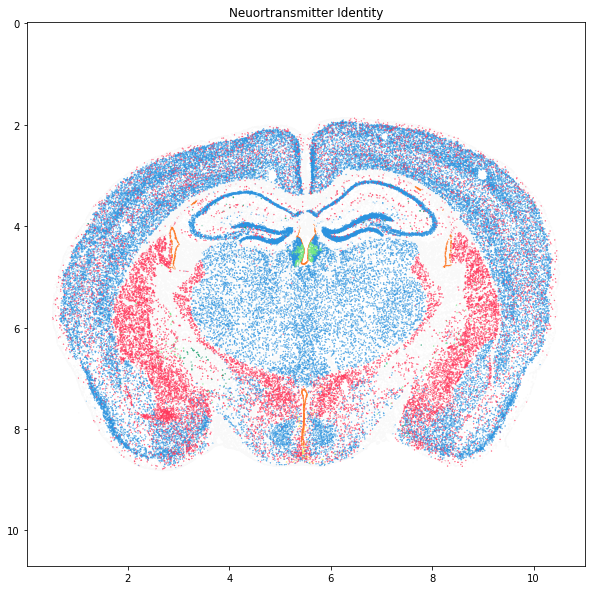

In [36]:
fig, ax = plot_section(cell_filtered['x'], cell_filtered['y'],cell_filtered['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter Identity")

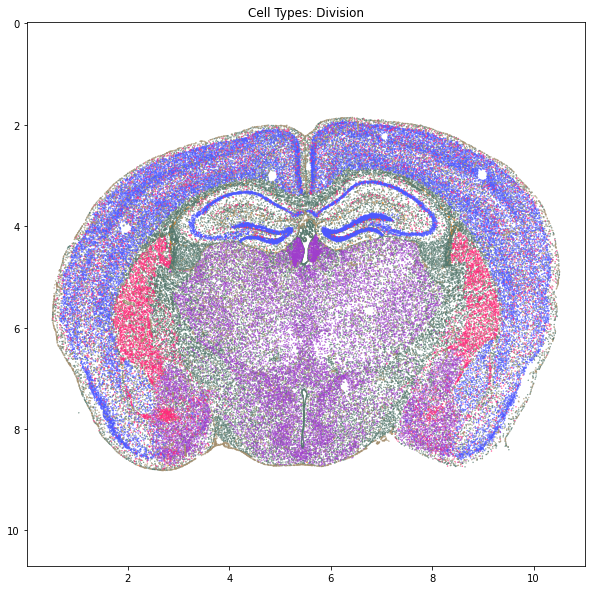

In [37]:
fig, ax = plot_section(cell_filtered['x'], cell_filtered['y'],cell_filtered['division_color'])
res = ax.set_title("Cell Types: Division")

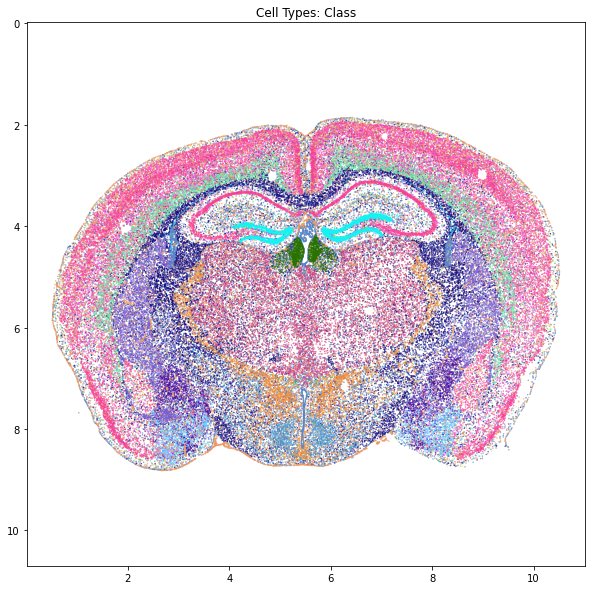

In [38]:
fig, ax = plot_section(cell_filtered['x'], cell_filtered['y'],cell_filtered['class_color'])
res = ax.set_title("Cell Types: Class")

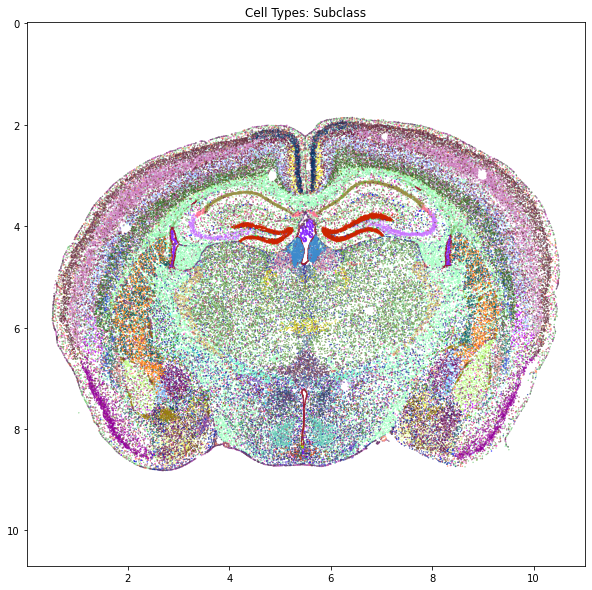

In [39]:
fig, ax = plot_section(cell_filtered['x'], cell_filtered['y'],cell_filtered['subclass_color'])
res = ax.set_title("Cell Types: Subclass")

## Example use cases

In this section, we explore the same two use cases as with the 10x data. The first example looks at the expression of nine canonical neurotransmitter transporter genes and the second the expression of gene Tac2. To support these use cases, we will create a smaller submatrix (all cells and 10 genes) that read it into memory. *Note this operation takes around 10 seconds*.

In [43]:
ntgenes = ['Slc17a7','Slc17a6','Slc17a8','Slc32a1','Slc6a5','Slc6a3','Slc6a4']
exgenes = ['Tac2']
gnames = ntgenes + exgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

,gene_symbol,transcript_identifier
gene_identifier,,
ENSMUSG00000030500,Slc17a6,ENSMUST00000032710
ENSMUSG00000037771,Slc32a1,ENSMUST00000045738
ENSMUSG00000025400,Tac2,ENSMUST00000026466
ENSMUSG00000039728,Slc6a5,ENSMUST00000056442
ENSMUSG00000070570,Slc17a7,ENSMUST00000085374
ENSMUSG00000019935,Slc17a8,ENSMUST00000020102
ENSMUSG00000021609,Slc6a3,ENSMUST00000022100
ENSMUSG00000020838,Slc6a4,ENSMUST00000021195


In [44]:
start = time.process_time()
asubset = adata[cell_filtered.index,gene_filtered.index].to_memory()
print("time taken: ", time.process_time() - start)
print(asubset)

time taken:  0.2469223470000088
AnnData object with n_obs × n_vars = 104679 × 8
    obs: 'brain_section_label'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


We define two helper functions to (1) *create_expression_dataframe*: create joined gene expression and cell metadata dataframe based for a set of input genes and (2) *aggregate_by_metadata* which computes the average expression for each term in a given category.

In [45]:
def create_expression_dataframe( ad, gf ) :
    gdata = ad[:,gf.index].to_df()
    gdata.columns = gf.gene_symbol
    joined = cell_filtered.join( gdata )
    return joined

In [49]:
def aggregate_by_metadata( df, gnames, value, sort = False ) :
    grouped = df.groupby(value)[gnames].mean()
    if sort :
        grouped = grouped.sort_values(by=gnames[0],ascending=False)
    return grouped

### Expression of canonical neurotransmitter transporter genes

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of cells in the 'C57BL6J-638850.40' section and expression of the 9 solute carrier family genes. We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group and visualized as a colorized table. The results are similar of the 10x data restricted to cells from the thalamus.

In [50]:
pred = [x in ntgenes for x in asubset.var.gene_symbol]
gf = asubset.var[pred]

ntexp = create_expression_dataframe( asubset, gf )
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
agg = agg[ntgenes]
agg.style.background_gradient(cmap='Reds')

,Slc17a7,Slc17a6,Slc17a8,Slc32a1,Slc6a5,Slc6a3,Slc6a4
neurotransmitter,,,,,,,
Chol,5.183920,1.864037,0.438873,0.184734,0.227340,0.034354,0.123137
Dopa,0.065551,0.621275,0.094441,3.614350,0.090577,3.524795,0.000000
GABA,1.339742,0.447065,0.156072,3.993876,0.145852,0.042546,0.037630
GABA-Glyc,1.479833,0.921879,0.000000,5.864266,0.000000,0.000000,0.000000
Glut,5.444790,1.425116,0.200327,0.473347,0.153790,0.042596,0.047748
Glut-GABA,1.848599,2.742454,2.250386,4.375583,0.212264,0.028847,0.100955
Hist,0.709733,0.336871,0.089416,0.118245,0.036308,0.014693,0.016475


The expression data can also be visualized as scatter point in anatomical context. Gene Slc17a7 is highly enriched in the cortex , hippocampus, medial habenula with some expression in the thalamus. On the other hand gene Slc32a1 is enriched in the striatum with sparse expression on the cortical plate.

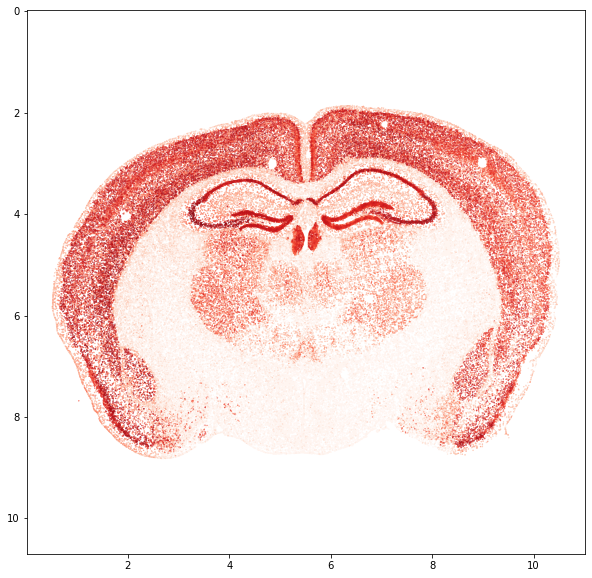

In [28]:
fig, ax = plot_section(ntexp['x'], ntexp['y'],val=ntexp['Slc17a7'],cmap='Reds')

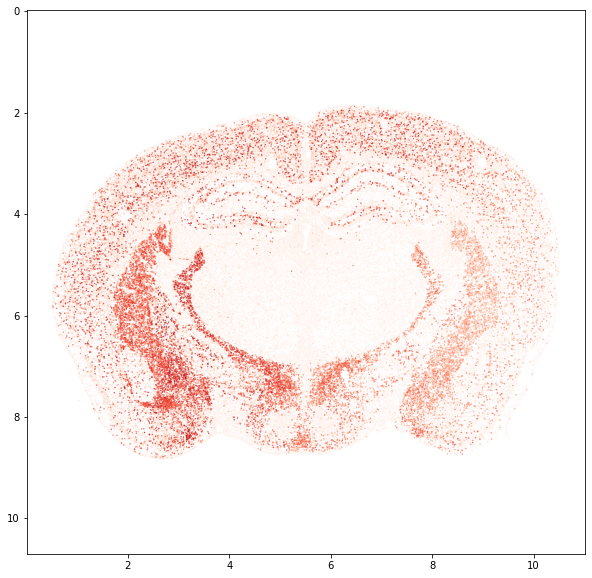

In [29]:
fig, ax = plot_section(ntexp['x'], ntexp['y'],val=ntexp['Slc32a1'],cmap='Reds')

### Expression of Tachykinin 2 (Tac2) in the whole brain

In mice, the tachykinin 2 (Tac2) gene encodes neuropeptide called neurokinin B (NkB). Tac2 is produced by neurons in specific regions of the brain know to be invovled in emotion and social behavior. Based on [ISH data](https://mouse.brain-map.org/experiment/siv?id=77279001&imageId=77284584&initImage=ish&coordSystem=pixel&x=5384.5&y=3832.5&z=3) from the Allen Mouse Brain Atlas, Tac 2 is sparsely expressed in the mouse isocortex and densely enriched is specific subcortical regions such the medial habenula (MH), the amygdala and hypothalamus.

<br>
<div>
<img src="Tac2_ISH_Coronal_Section.JPG" width="600"/>
</div>


In this example, we create a dataframe comprising of cells in section 'C57BL6J-638850.40' and expression values of Tac2 in those cells.

In [56]:
gf = asubset.var[asubset.var.gene_symbol == 'Tac2']
tac2 = create_expression_dataframe( asubset, gf )

Grouping cells by neurotransmitter identites and computing the mean expression in each group, we can observed that Tac2 gene is highly enriched in cholinergic cell types with some expression in Glut-GABA types.

In [57]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'neurotransmitter', True).head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
neurotransmitter,
Chol,3.680775
Glut-GABA,0.993722
Hist,0.430916
GABA,0.338095
Glut,0.231285
Dopa,0.189615
GABA-Glyc,0.000000


Grouping cells by cell types class, shows that Tac2 is enriched in class "08 MH-LH Glut" with cells restricted to the medial (MH) and lateral (LH) habenula and a mixture of glutamatergic and cholinergic types.

In [33]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'class', True).head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
class,
08 MH-LH Glut,3.499806
04 CGE GABA,0.944515
14 CNU-HYa GABA,0.722276
03 MOB-DG-IMN,0.300375
11 HY GABA,0.248390
15 HY Glut,0.241608
13 CNU-HYa Glut,0.222395
28 Astro-Epen,0.179213


At the next level, grouping by subclass, shows Tac2 is enriched in sublcasses with specificity to the medial habenula (MH), bed muclei of the stria terminalis (BST) and main olfactory blub (MOB).

In [34]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'subclass', True).head(8)
agg.style.background_gradient(cmap='Reds')

,Tac2
subclass,
105 BST Tac2 Gaba,5.585082
063 MH Tac2 Glut,4.285685
276 MOB-mi Frmd7 Gaba,3.747643
036 Vip Gaba,1.697409
053 MSN D1 Sema5a Gaba,1.672699
037 Sncg Gaba,1.539363
095 CEA-BST Crh Gaba,1.536608
289 Astroependymal NN,1.440536


Plotting gene expression in anatomical coordinates results in a image that is comparable to the ISH image data for the same gene.

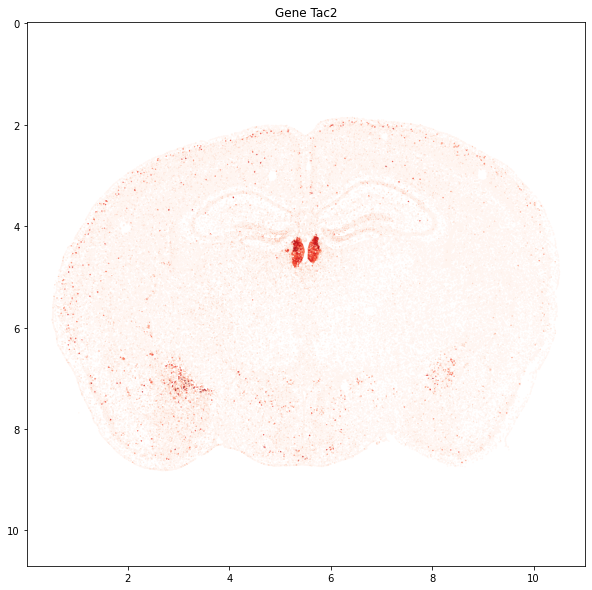

In [58]:
fig,ax = plot_section(tac2['x'], tac2['y'],val=tac2['Tac2'],cmap='Reds')
res = ax.set_title('Gene Tac2')